# Text to Image Synthesis with notebooks
## Understand the contents of dataset
In this notebook, we will:

    1. Use the Caltech UCSD Birds 200 2011 (CUB-200-2011) dataset and generated description (by Learning Deep Representations of Fine-grained Visual Descriptions)
    
    2. Investigate the images and their descriptions
    
    3. Display them

This code is based on Text-to-Image-Synthesis, caltech_birds
- https://github.com/aelnouby/Text-to-Image-Synthesis
- https://github.com/ecm200/caltech_birds

In [180]:
import os
import io
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import pdb
from PIL import Image
import torch
from torch.autograd import Variable
import pdb
import torch.nn.functional as F

In [181]:
class Text2ImageDataset(Dataset):
    def __init__(self, dataset_dir, transform=None, split=0):
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.dataset = None
        self.dataset_keys = None
        self.split = 'train' if split == 0 else 'valid' if split == 1 else 'test'
        self.h5pyint = lambda x:int(np.array(x))
        
    def __len__(self):
        f = h5py.File(self.dataset_dir, 'r')
        self.dataset_keys = [str(k) for k in f[self.split].keys()]
        length = len(f[self.split])
        f.close()
        return length
    
    def __getitem__(self, idx):
        if self.dataset is None:
            self.dataset = h5py.File(self.dataset_dir, mode='r')
            self.dataset_keys = [str(k) for k in self.dataset[self.split].keys()]
        
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        
        right_image = bytes(np.array(example['img']))
        right_embed = np.array(example['embeddings'], dtype=float)
        
        right_image = Image.open(io.BytesIO(right_image)).resize((64, 64))
        right_image = self.validate_image(right_image)
        txt = np.array(example['txt']).astype(str)
        
        sample = {
            'right_images' : torch.FloatTensor(right_image),
            'right_embed' : torch.FloatTensor(right_embed),
            'txt': str(txt)
            }
        sample['right_images'] = sample['right_images'].sub_(127.5).div_(127.5)
        
        return sample
    
    def validate_image(self, img):
        img = np.array(img, dtype=float)
        if len(img.shape) < 3:
            rgb = np.empty((64, 64, 3), dtype=np.float32)
            rgb[:, :, 0] = img
            rgb[:, :, 1] = img
            rgb[:, :, 2] = img
            img = rgb
        return img.transpose(2, 0, 1)

In [182]:
batch_size = 8
num_workers = 0
dataset_dir = 'D:\PycharmProjects\Text-to-Image-Synthesis-master/birds.hdf5'
dataset = Text2ImageDataset(dataset_dir)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [183]:
data_iterator = iter(dataloader)
sample = next(data_iterator)
sample

{'right_images': tensor([[[[-0.2863, -0.2941, -0.2863,  ..., -0.3804, -0.3804, -0.3804],
           [-0.2863, -0.2941, -0.2863,  ..., -0.3961, -0.3961, -0.4039],
           [-0.3647, -0.2627, -0.3098,  ..., -0.4118, -0.4510, -0.3961],
           ...,
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  0.9451],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],
 
          [[ 0.1216,  0.0824,  0.0980,  ...,  0.0118,  0.0118,  0.0039],
           [ 0.1059,  0.0902,  0.1216,  ..., -0.0039, -0.0039, -0.0196],
           [ 0.0431,  0.0980,  0.1216,  ..., -0.0118, -0.0510, -0.0118],
           ...,
           [ 0.9843,  0.9843,  0.9843,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],
 
          [[ 0.4902,  0.6000,  0.5373,  ...,  0.4902,  0.4745,  0.4588

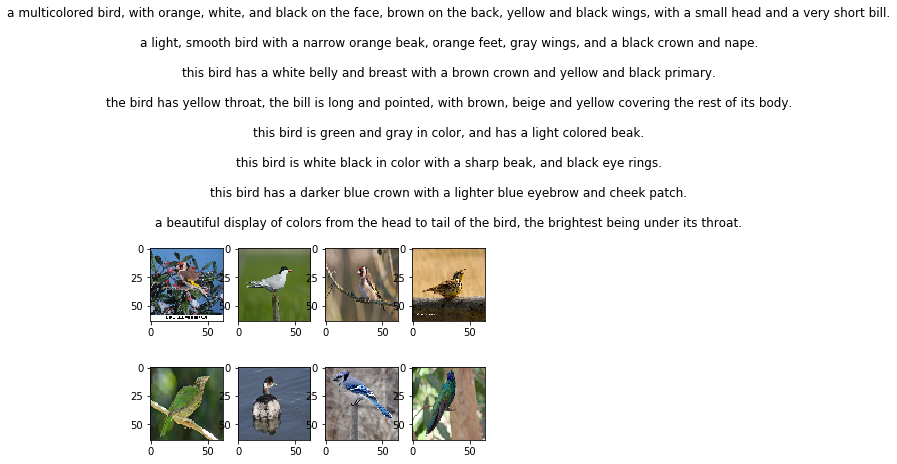

In [184]:
import torchvision
import matplotlib.pyplot as plt
npics = 4

fig = plt.figure()

def multiple_imshow(fig, sample, idx):
    out = sample['right_images'][idx]
    out = out.data.mul_(127.5).add_(127.5).permute(1, 2, 0).byte().cpu().numpy()
    ax = fig.add_subplot(batch_size/npics, npics, idx+1)
    plt.imshow(out)
    
final_title = ''
for i in range(batch_size):
    multiple_imshow(fig, sample, i)
    final_title += str(sample['txt'][i]) + '\n'
    
plt.title(final_title, pad=110)
plt.show()